Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Importing Skin Cancer Data

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

# Loading the data
train_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
test_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'Train - {image_count_train}')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'Test - {image_count_test}')

Train - 2239
Test - 118


### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

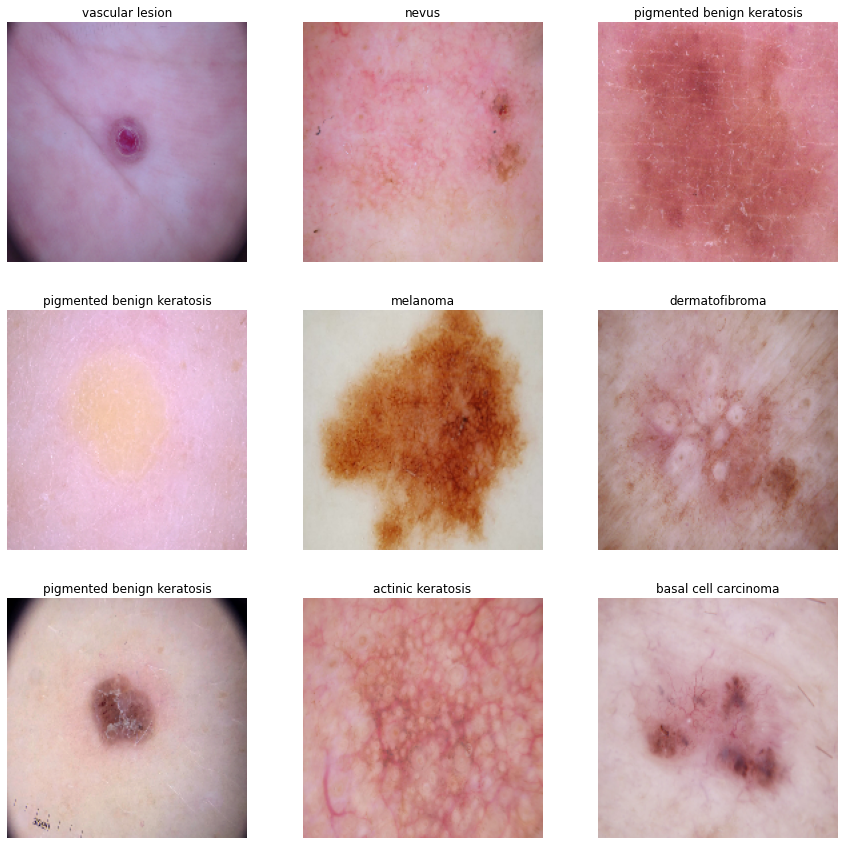

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# Normalizing pixel values between (0,1)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Verify if pixel values are in range `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.018201986 0.80238336


In [12]:
# Storing number of classes in data
num_classes = len(class_names)

In [13]:
# Building the model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [14]:
### Using optimiser - Adam and loss function - SparseCategoricalCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 23s 398ms/step - loss: 1.9965 - accuracy: 0.2829 - val_loss: 1.6683 - val_accuracy: 0.3758
Epoch 2/20
56/56 [==============================] - 22s 393ms/step - loss: 1.5794 - accuracy: 0.4319 - val_loss: 1.8160 - val_accuracy: 0.3624
Epoch 3/20
56/56 [==============================] - 24s 428ms/step - loss: 1.5025 - accuracy: 0.4855 - val_loss: 1.3950 - val_accuracy: 0.5503
Epoch 4/20
56/56 [==============================] - 23s 418ms/step - loss: 1.4019 - accuracy: 0.5195 - val_loss: 1.4108 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 23s 411ms/step - loss: 1.2584 - accuracy: 0.5608 - val_loss: 1.4635 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 23s 418ms/step - loss: 1.1759 - accuracy: 0.5787 - val_loss: 1.4352 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 24s 426ms/step - loss: 1.0930 - accuracy: 0.6099 - val_loss: 1.5954 - val_accuracy: 0.5034

### After 20 epochs, we have -
- ##### Training accuracy : ~0.89 and Validation accuracy : ~0.53. Clearly shows signs of overfitting.

### Visualizing training results

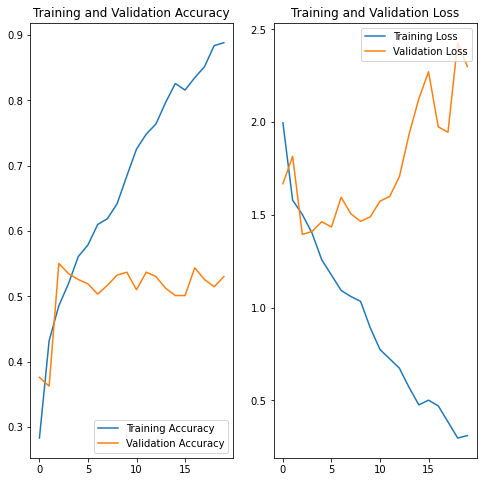

In [17]:
# Storing accuracy for visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Storing Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Findings after the model fit:
1. We can see a significant drop in validation accuracy and an increase in validation loss.
2. Validation accuracy is on par with training accuracy in the initial stage
3. There is a significant increase in training accuracy while validation accuracy is decreasing.

#### Evidence whether the model is overfit or underfit:
1. Since the training accuracy is too high ~0.89 the model is not underfit
2. There are clear signs of overfitting from validation accuracy of ~0.53 when compared to training accuracy of ~0.89

In [18]:
# An appropriate data augumentation strategy for overfit - Random flip
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1) ])

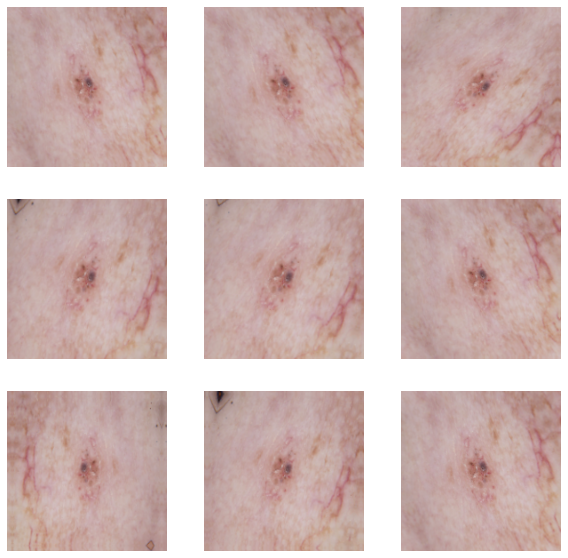

In [19]:
# Visualize how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    aug_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(aug_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [20]:
## Creating a model - Using Dropout layer as there is an evidence of overfitting in the findings

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [21]:
### Using optimiser - Adam and loss function - SparseCategoricalCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [23]:
## Training the model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 26s 445ms/step - loss: 2.0214 - accuracy: 0.2567 - val_loss: 1.7259 - val_accuracy: 0.4004
Epoch 2/20
56/56 [==============================] - 25s 442ms/step - loss: 1.6056 - accuracy: 0.4302 - val_loss: 1.7127 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 25s 445ms/step - loss: 1.5178 - accuracy: 0.4704 - val_loss: 1.5248 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 27s 479ms/step - loss: 1.4380 - accuracy: 0.4961 - val_loss: 1.5185 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 28s 497ms/step - loss: 1.3158 - accuracy: 0.5340 - val_loss: 1.3159 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 28s 508ms/step - loss: 1.2812 - accuracy: 0.5363 - val_loss: 1.3964 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 29s 513ms/step - loss: 1.2930 - accuracy: 0.5346 - val_loss: 1.3846 - val_accuracy: 0.4966

 ### After 20 epochs we have -
 - ##### Training Accuracy   : ~ 0.58 and Validation Accuracy : ~ 0.53

### Visualizing the results

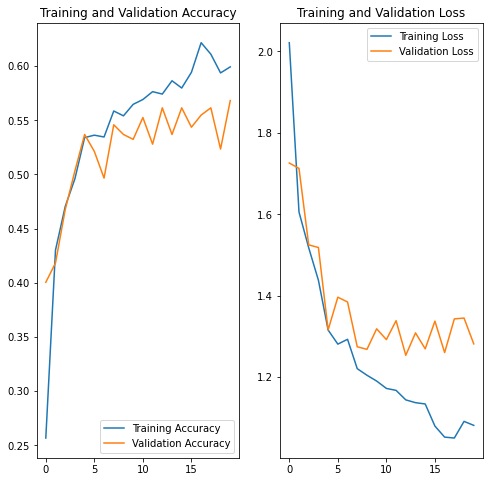

In [24]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit:
1. There is less gap between training and validation accuracy, and we can observe that it is a decent model to work with.
2. We can observe some spikes in the validation accuracy and loss, which is quite less in the training accuracy and loss.
3. These distortions/ spikes may be due to class imbalance in the dataset.

#### Evidence of model overfit or underfit:
1. Training accuracy: ~0.60 and Validation accuracy: ~0.57
2. So there is no clear evidence of overfit or underfit

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

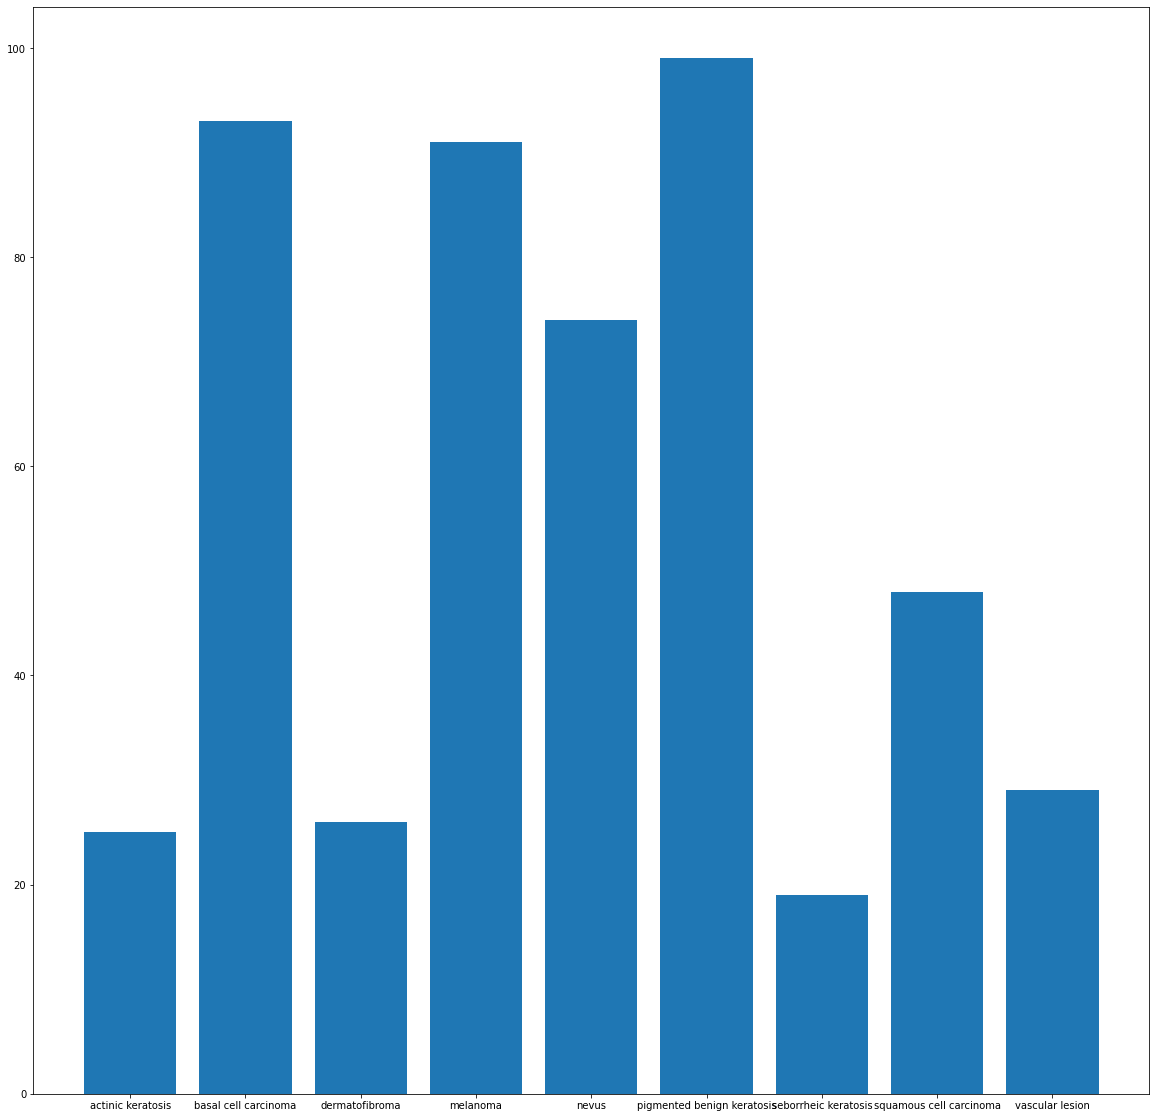

In [25]:
## Visualising the dataset to find class imbalance

# Creating lists for each class 
data = dict()
for i in class_names:
    data[i] = []

# Storing the images of all class names in data
for images, labels in train_ds:
    for i in range(len(class_names)):
        data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

# Storing the count of images present
for i in data:
    data[i] = len(data[i])
    
# Plotting the data
plt.figure(figsize=(20, 20))
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### Findings:
- Seborrheic keratosis class has the least number of samples
- Pigmented Benign Keratosis class dominate the data in terms of number of samples

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset=train_path

# Importing Augmentor package
import Augmentor

# Training with Pipeline object
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C504EC71C0>: 100%|█| 500/500 [00:03<00:00, 156.30 Samples


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2C500BB3190>: 100%|█| 500/500 [00:03<00:


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C504E25C10>: 100%|█| 500/500 [00:03<00:00, 141.58 Samples


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2C504EE48B0>: 100%|█| 500/500 [00:16<00:00, 30.15 Samples


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x2C500410610>: 100%|█| 500/500 [00:16<00:


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C50076CD60>: 100%|█| 500/500 [00:03<00:00, 139.79 Samples


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2C5738B68B0>: 100%|█| 500/500 [00:08<00:00, 61.73 Samples


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2C504E70DC0>: 100%|█| 500/500 [00:03<00:


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C50015A670>: 100%|█| 500/500 [00:03<00:00, 129.71 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(f' Training image count - {image_count_train}')

 Training image count - 4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob

In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3568c00f-434d-42fe-a521-710dfb4b8b2d.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_02d754d2-8478-4847-86a1-7cb21a33b020.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_032eecce-008e-470f-aa9e-634ba46c37c2.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_07e2e0d9-c1ae-43e6-a107-d733428dd2cc.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_aef102d9-6f5e-407b-9916-a071b0dc3a88.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
# Creating a dictionary
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
# Creating a dataframe
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [34]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [36]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating the model (make sure to include normalization)

In [38]:
# Performing autotune
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
# Normalizing pixel values between (0,1)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Verify the pixel values are now in the range (0,1)
print(np.min(first_image), np.max(first_image))

0.00081697357 0.84264714


In [40]:
# creating a model with no class imbalance
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile the model (Choose optimizer and loss function appropriately)

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
# Viewing the summary results
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

#### Train your model

In [43]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 79s 461ms/step - loss: 1.8353 - accuracy: 0.2930 - val_loss: 1.5326 - val_accuracy: 0.4076
Epoch 2/30
169/169 [==============================] - 74s 440ms/step - loss: 1.4941 - accuracy: 0.4258 - val_loss: 1.3511 - val_accuracy: 0.5033
Epoch 3/30
169/169 [==============================] - 73s 432ms/step - loss: 1.4049 - accuracy: 0.4672 - val_loss: 1.2527 - val_accuracy: 0.5152
Epoch 4/30
169/169 [==============================] - 74s 440ms/step - loss: 1.3281 - accuracy: 0.4948 - val_loss: 1.2763 - val_accuracy: 0.5249
Epoch 5/30
169/169 [==============================] - 74s 440ms/step - loss: 1.2561 - accuracy: 0.5211 - val_loss: 1.2196 - val_accuracy: 0.5442
Epoch 6/30
169/169 [==============================] - 74s 436ms/step - loss: 1.1914 - accuracy: 0.5508 - val_loss: 1.1444 - val_accuracy: 0.5872
Epoch 7/30
169/169 [==============================] - 74s 437ms/step - loss: 1.1492 - accuracy: 0.5668 - val_loss: 1.1171 - val_ac

#### Visualize the model results

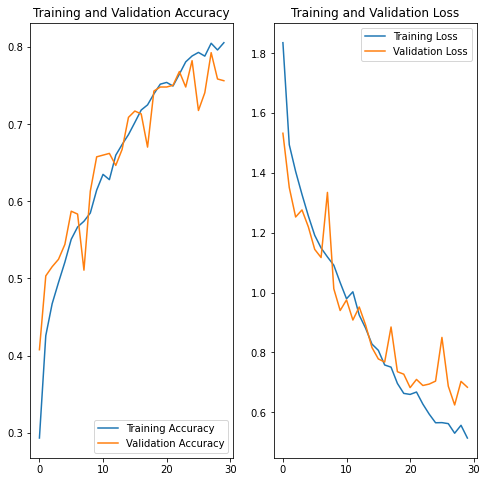

In [44]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis of the results:
- As we can see training accuracy and validation accuracy is following the same trend.
- Training accuracy = 0.80 and validation accuracy = 0.75

#### Did you get rid of underfitting/overfitting? 
The final model is neither overfits nor underfits. Overfitting situation has been handled.

#### Did class rebalance help?
Class rebalance clearly helped as there are no too many distortions/spikes in the validation compared to training
